In this file, I only focus on predicting a time-series by using `ARIMA` and `SARIMA` model

## 0. Import libraries & viewing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

df1 = pd.read_csv(r"D:\Nhan\Data\AirPassengers.csv")
df1.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [2]:
df2 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv')

print(df1.shape, df2.shape)
df2.head()

(144, 2) (100, 1)


,x
0,88
1,84
2,85
3,85
4,84


## 1. Introduction to `ARIMA models`

A popular and widely used statistical method for time series forecasting is the **`ARIMA model`**. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

**`ARIMA`** is an `acronym` that stands for **`AutoRegressive Integrated Moving Average`**. It is a class of model that captures a suite of different standard temporal structures in time series data.

This `acronym` is descriptive, capturing the key aspects of the model itself. Briefly, they are:

> `AR: Autoregression`. A model that uses the `dependent relationship` between an observation and some number of lagged observations.
>
> `I: Integrated`. The use of `differencing of raw observations` (e.g. `subtracting an observation from an observation at the previous time step`, that is $\Delta_t = x_t - x_{t-1}$ ) in order to make the `time series stationary`, Reminder. 
>
>> A time-series $(X_t)_{t \geq 0}$ is said to be `stationary` if for all $t, s, h$ then

$$ \mathbb{E}X_t = \mu , \quad \mathbb{E}X^2_t < \infty \text{ and } \text{Cov}\left( X_t, X_s \right) = \text{Cov}\left( X_{t+h}, X_{s+h} \right)  $$
>
>> In intuition (by graph / plot), in a **`stationary time series`**; data does not have any upward or downward trend or seasonal effects; this meant `Mean or variance` are `consistent over time`. 
>
>> In **`non-stationary time series`**: data show `trends`, `seasonal` effects, and `other structures depend on time`. Forecasting performance is dependent on the time of observation. `Mean and variance change over time and a drift in the model is captured`.
>
>> See the illustration bellow! The *`top panel`* is the plot of `white-noise` $x_t \sim \mathcal{N}(0, 1)$ which be `stationary time-series` while the *`middle & bottom-panels`* are the plots of the number of passengers and usages in the dataset `AirPassengers.csv` and `wwwusage.csv` respectively which increase over time.

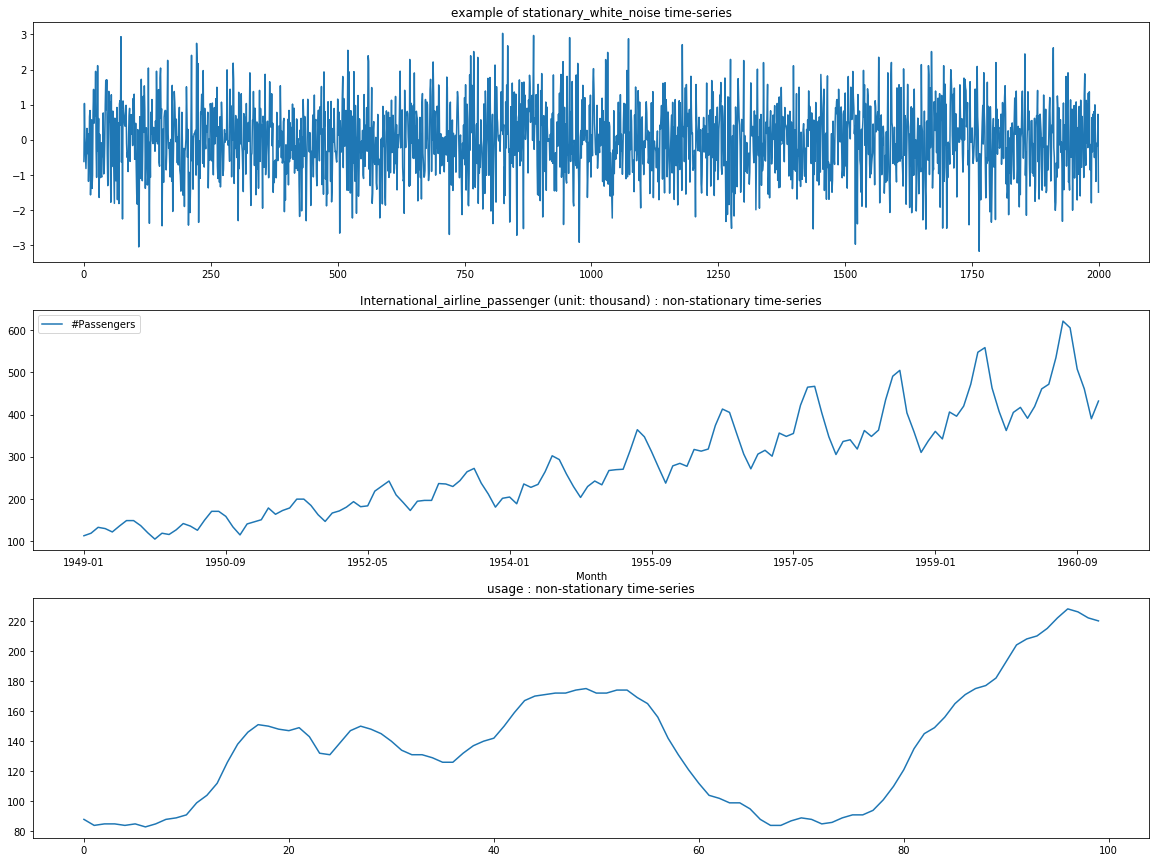

In [3]:
white_noise = np.random.normal(0, 1, size = 2000)

series_1 = df1.set_index('Month')
series_2 = df2.x

fig, axes = plt.subplots(3, 1, figsize = (20, 15))
axes[0].plot(white_noise)
axes[0].set_xticks(range(0, 2001, 250), 
           ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])
axes[0].set_title('example of stationary_white_noise time-series')

series_1.plot(title = 'International_airline_passenger (unit: thousand) : non-stationary time-series',
              ax = axes[1])

series_2.plot(title = 'usage : non-stationary time-series' , 
              ax = axes[2]);

> `MA: Moving Average.` A model that `uses the dependency between an observation` and a `residual error` from a `moving average` model applied to `lagged observations`.

### What does the `p`, `d` and `q` in ARIMA(p, d, q) model mean?

**The first step to build an ARIMA model is to make the time series stationary.**

A `linear regression model` is constructed including the specified number and type of terms, and the data is prepared by a `degree of differencing` in order to `make it stationary`, i.e. to `remove trend` and `seasonal structures` that negatively affect the `regression model`.

**So how to make a series stationary?**

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

Each of these components are explicitly specified in the model as a parameter. 

A `standard notation` is used of `ARIMA(p,d,q)` where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. The `parameters` of the `ARIMA model` are defined as follows:

> `d:` The `number of times that the raw observations are differenced`, also called the degree of differencing.
>> The value of `d`, therefore, is the `minimum number of differencing` needed to `make the series stationary`. And if the time series is `already stationary, then d = 0`. 
>
>> A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the `ARIMA model` can be configured to perform the `function of an ARMA model`, and even a simple `AR`, `I`, or `MA model`.
>
> `p:` The `number of lag observations` included in the model, also called the `lag order` of `‘Auto Regressive’ (AR) term`.. It refers to the number of lags of Y to be used as `predictors`.
>
>> A **`pure Auto Regressive (AR only)`** model is one where $Y_t$ `depends only on its own lags`. That is, $Y_t$ is a `function` of the `‘lags of` $Y_t$ `’`.
$$ (\text{AR}) \quad Y_t = \beta_0 + \beta_1 Y_{t-1} + \ldots + \beta_p Y_{t -p} + \varepsilon_1 $$
> where, $Y_{t-1}$ is the `lag_1` of the series, $\beta_k, k = 1,\ldots, p$ is the coefficient of `lag_k` that the model estimates and $\beta_0$ is the intercept term, also estimated by the model.
>
> `q:` The `size of the moving average window`, also called the `order of moving average (MA) term`. It refers to the `number of lagged forecast errors` that should go into the ARIMA Model.
>> Likewise, a **`pure Moving Average (MA only)`** model is one where $Y_t$ depends only on the lagged forecast errors.
$$ (\text{MA}) \quad Y_t = \beta_0 + \varepsilon_t + \alpha_1 \varepsilon_{t-1} + \ldots + \alpha_q \varepsilon_{t-q} $$
>> where the `error terms` are the `errors of the autoregressive models of` the respective `lags`. 

An `ARIMA` model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:
$$ (\text{ARIMA}) \quad Y_t = \beta_0 + \beta_1 Y_{t-1} + \ldots + \beta_p Y_{t -p} + \varepsilon_t + \alpha_1 \varepsilon_{t-1} + \ldots + \alpha_q \varepsilon_{t-q} $$


Adopting an `ARIMA` model for a time series assumes that the underlying process that generated the observations is an `ARIMA` process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.


### 1.1. Reminder: Checking for Stationarity

- using `plots` from `histogram` or `line-plot`

- using `Summary Statistics`

**A. Using `plots`**

For the `line-plot` (look back the `Line [2]`), sequence plot (at the `bottom (Air_passengers)`) obviously shows an `upward trend` as time goes by. We can also observe `seasonal trends` from similar shape in each year so this is `non-stationary` while the `top` is consistent at mean and variance!

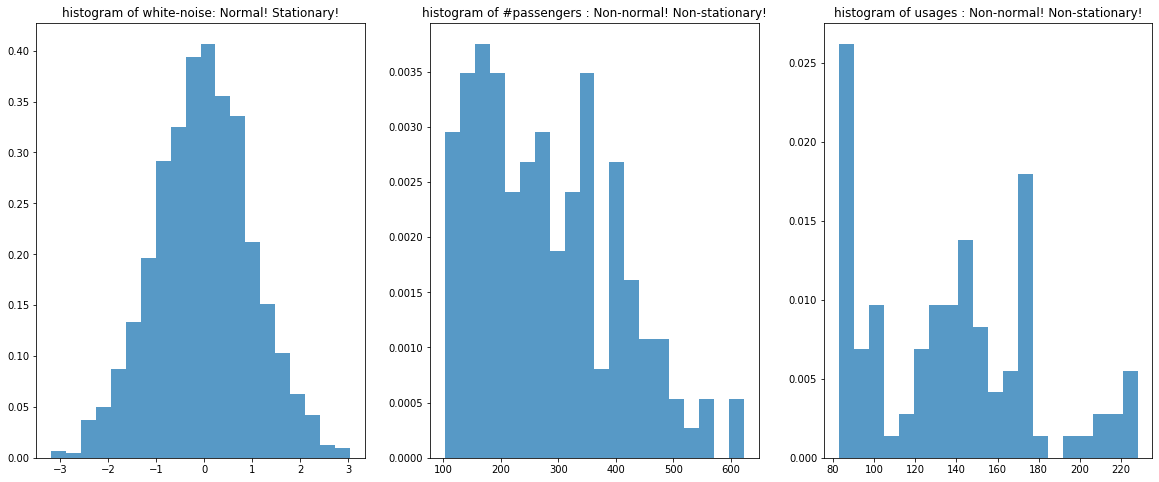

In [4]:
plt.figure(figsize = (20, 8))

plt.subplot(131), plt.hist(x = white_noise, bins = 20, density = True, alpha=0.75), 
plt.title('histogram of white-noise: Normal! Stationary!')

plt.subplot(132), plt.hist(x = series_1.values, bins = 20, density = True, alpha=0.75),
plt.title('histogram of #passengers : Non-normal! Non-stationary!')

plt.subplot(133), plt.hist(x = series_2.values, bins = 20, density = True, alpha=0.75),
plt.title('histogram of usages : Non-normal! Non-stationary!')

plt.show()

In these histogram, if the data is `stationary (left panel)` the summary statistics should be consistent over time. The mean should be consistent with a consistent variance indicating a Gaussian distribution. In the `middle & right panels`, the histograms do not show `Gaussian distribution` and another indication of `non-stationary` time series data.

#### B. Using `Summary Statistics`

In [5]:
time_series = [white_noise, series_1.values, series_2.values]
titles = ['Stationary ts', 'Non-stationary ts, df1', 'Non-stationary ts, df2']

for k in range(3):
    print(titles[k], ':')
    X = time_series[k]
    split = len(X) // 3
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('\tmean1 = %.3f, mean2 = %.3f' % (mean1, mean2))
    print('\tvariance1 = %.3f, variance2 = %.3f' % (var1, var2))

Stationary ts :
	mean1 = -0.040, mean2 = -0.009
	variance1 = 0.960, variance2 = 1.044
Non-stationary ts, df1 :
	mean1 = 158.375, mean2 = 341.260
	variance1 = 1071.859, variance2 = 9753.005
Non-stationary ts, df2 :
	mean1 = 119.909, mean2 = 145.537
	variance1 = 716.143, variance2 = 1794.637


**`Summary Statistics`**, the mean and variance are very different from the first and second half of the data. Another indication of non-stationary data.

#### C. `Augmented Dickey-Fuller test (ADF)`

`ADF` tests the null hypothesis that a unit root is present in time series sample. `ADF` statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.
> `Null Hypotehsis (H0)`: If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
>
> `Alternate Hypothesis (H1)`: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
>
> `p-value > 0.05`: `Accept H0`, the data `has a unit root` and is `non-stationary`
>
> `p-value ≤ 0.05`: `Reject H0`. the data `does not have a unit root` and is `stationary`

In [6]:
from statsmodels.tsa.stattools import adfuller

ts = [series_1.values, series_2.values, white_noise]
titles = ['#passenger_ts', '#usages_ts', 'white_noise_ts'] 

for k in range(3):
    X = ts[k]
    print('For time-series = %s'%titles[k])
    result = adfuller(X)
    print('\tADF Statistic: %f' % result[0])
    print('\tp-value: %f' % result[1])
    print('\tCritical Values:')
    for key, value in result[4].items():
        print('\t\t%s: %.3f' % (key, value))

For time-series = #passenger_ts
	ADF Statistic: 0.815369
	p-value: 0.991880
	Critical Values:
		1%: -3.482
		5%: -2.884
		10%: -2.579
For time-series = #usages_ts
	ADF Statistic: -2.464240
	p-value: 0.124419
	Critical Values:
		1%: -3.500
		5%: -2.892
		10%: -2.583
For time-series = white_noise_ts
	ADF Statistic: -43.430389
	p-value: 0.000000
	Critical Values:
		1%: -3.434
		5%: -2.863
		10%: -2.568


`ADF Stat` has a `p-value` is also `above 0.05`. The data is closer to being stationary, but still has a `unit root` and is `non-stationary`. 

Obviously, for `X = white_noise` then the `ADF Stat` will return `stationary`.

### 1.2. How to determine the params `d, p, q`

#### 1.2.1.  Finding the order of differencing (d)

`The purpose of differencing it to make the time series stationary`.

But we need to be careful to `not over-difference the series`. Because, an `over differenced series` may still be `stationary`, which in `turn will affect the model parameters`.

> => So how to determine the right order of differencing?

The `right order of differencing` is the `minimum differencing` required to get a `near-stationary series` which `roams around` a defined mean and the `ACF plot` reaches to zero fairly quick.

- If the `autocorrelations` are positive for many `number of lags` (10 or more), then the `series needs further differencing`. 

- On the other hand, if the `lag 1 autocorrelation itself is too negative`, then the `series` is `probably over-differenced`.

In the event, you `can’t really decide` between `two orders of differencing`, then go with the order that gives the `least standard deviation` in the differenced series.

> **Step 1**. Using `ADF Test` to find `p_value`. 
>
>>If `p_value > 0.05` we go ahead with finding the order of differencing.
>
>> Noting that the `null hypothesis` of the `ADF test` is that the `time series is non-stationary`. So, if the `p-value` of the test is less than the `significance level (alpha = 0.05)` then you reject the null hypothesis and infer that the time series is indeed stationary.
>
> **Step 2** `Differencing the series` and see how the `autocorrelation plot` looks like

#### Example 1. Find `d` for the time-series in `df2`

In this dataset, the `p_value = 0.124419 >> 0.05`, so we will use `acf_plot` to check stationary

In [7]:
def diff_time_series(series, d = 1):
    if d == 0:
        ts = series
    elif d == 1:
        ts = series.diff()
    else:
        ts = diff_time_series(series, d = d-1).diff()
    return ts

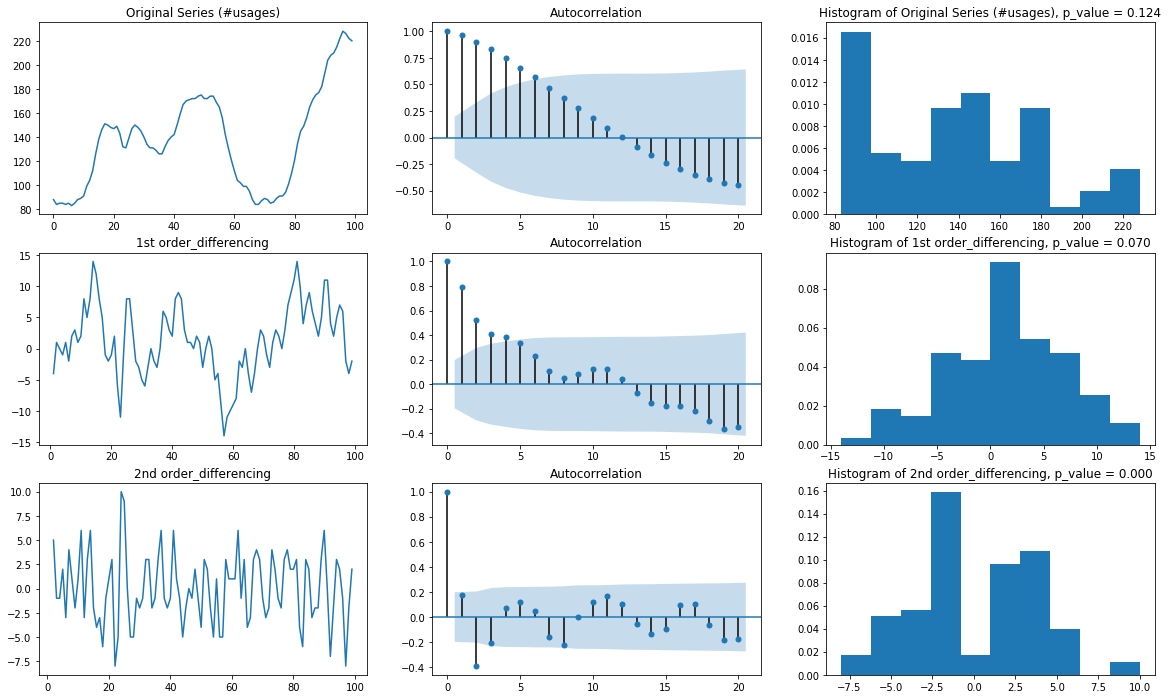

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

titles = ['Original Series (#usages)', '1st order_differencing', '2nd order_differencing']
fig, axes = plt.subplots(3, 3, figsize = (20, 12))
for k in [0, 1, 2]:
    axes[k, 0].plot(diff_time_series(series_2, d = k).values)
    axes[k, 0].set_title(titles[k])
    result = adfuller(diff_time_series(series_2, d = k).dropna())
    plot_acf(diff_time_series(series_2, d = k).dropna(), ax = axes[k, 1])
    axes[k, 2].hist(diff_time_series(series_2, d = k).dropna(), density = True)
    axes[k, 2].set_title('Histogram of %s, p_value = %.3f'%(titles[k], result[1]))

> For the above series, the `time series` reaches `stationarity` with `two order of differencing`, **`but`** on looking at the `autocorrelation plot` for the `2nd differencing` the **`lag`** goes into the **`far negative zone fairly quick`**, which `indicates`, the `series` might have been **`over differenced`**.
>
> Hence, we will tentatively fix the order of differencing as **`d = 1`** even though the series is `not perfectly stationary` (or `weak stationarity`).

#### Example 2. Find `d` for the time-series in `df1`

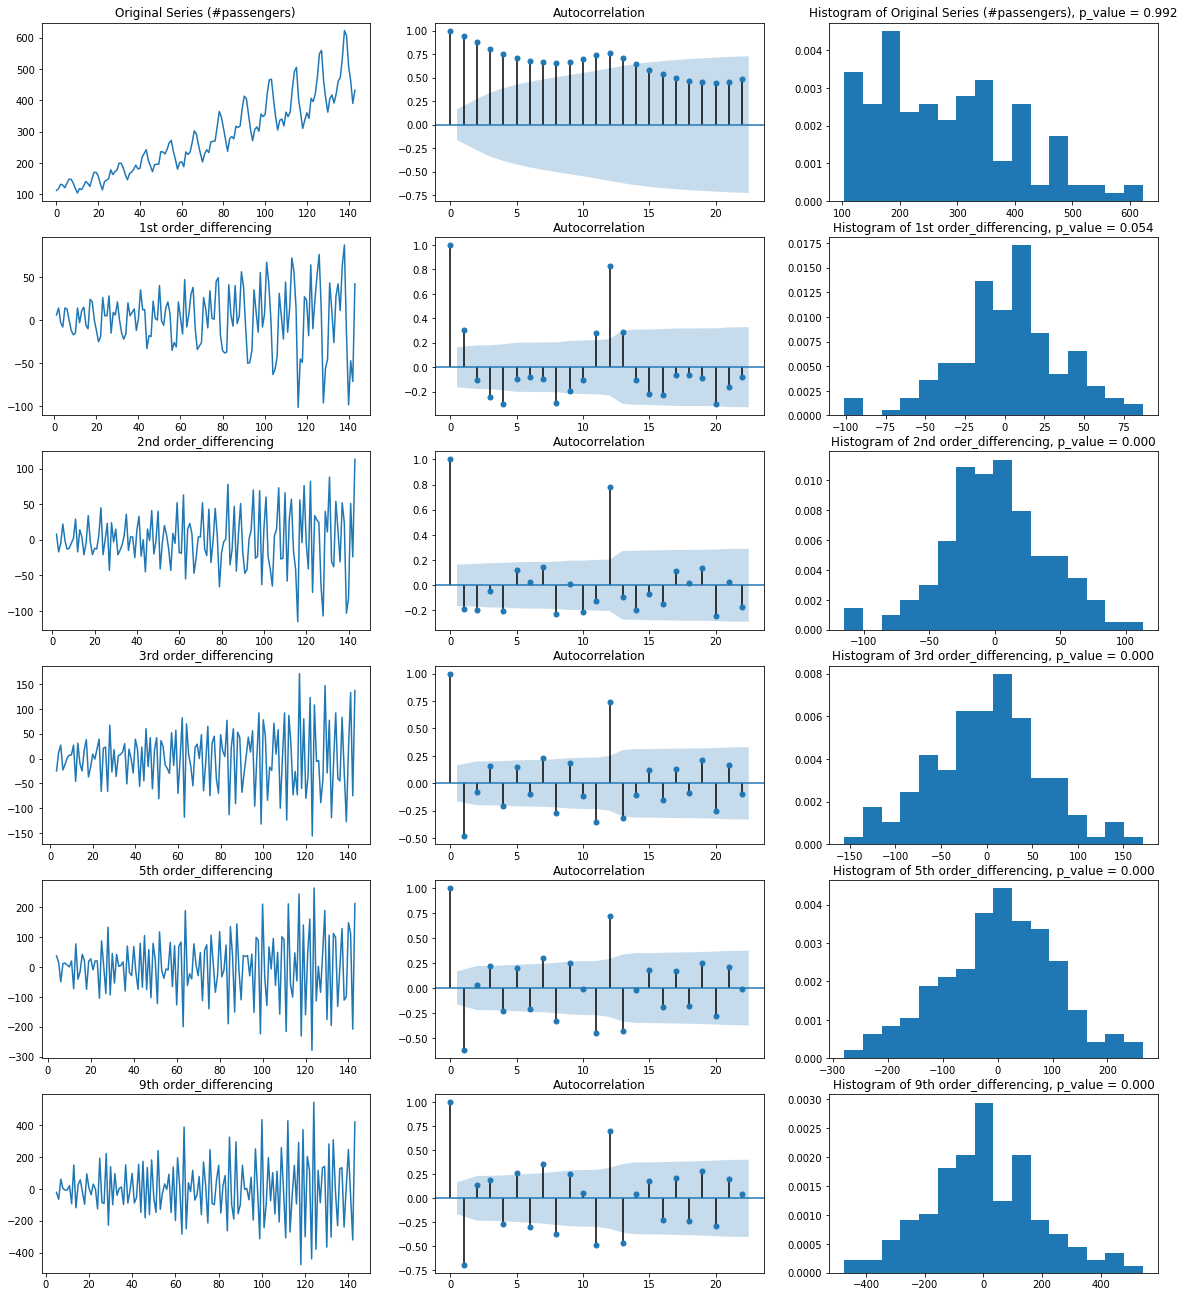

In [9]:
titles = ['Original Series (#passengers)', '1st order_differencing', '2nd order_differencing',
         '3rd order_differencing', '5th order_differencing', '9th order_differencing']
fig, axes = plt.subplots(6, 3, figsize = (20, 23))
for k in range(6):
    axes[k, 0].plot(diff_time_series(series_1, d = k).values)
    axes[k, 0].set_title(titles[k])
    result = adfuller(diff_time_series(series_1, d = k).dropna())
    plot_acf(diff_time_series(series_1, d = k).dropna(), ax = axes[k, 1])
    axes[k, 2].hist(diff_time_series(series_1, d = k).dropna().values, bins = 16, density = True)
    axes[k, 2].set_title('Histogram of %s, p_value = %.3f'%(titles[k], result[1]))

So, for this dataset, we will pick `d = 1` although this is really hard to choose which one is better! 

Choosing `d >= 2` can make the `series` become `stationary` but might have been `over differenced`.

### Using `ndiffs` (find the maximum_value of `d`).
Noting that this function `estimated differencing term`. This is the maximum value of ``d`` such that ``d <= max_d`` and the time series is `judged stationary`.
        
If the `time series` is `constant` or `already stationary`, will return 0.

In [10]:
#!pip install pmdarima
from pmdarima.arima.utils import ndiffs

ts = [series_1.values, series_2.values, white_noise]
titles = ['#passenger_ts', '#usages_ts', 'white_noise_ts'] 
crits = ['adf', 'kpss', 'pp']
for idx, tit in enumerate(titles):
    print('Considering %s:'%tit)
    for crit in crits:
        print('\tcrit = %s, ndiff = %s'%(crit, ndiffs(ts[idx], test = crit)))

Considering #passenger_ts:
	crit = adf, ndiff = 0
	crit = kpss, ndiff = 1
	crit = pp, ndiff = 0
Considering #usages_ts:
	crit = adf, ndiff = 2
	crit = kpss, ndiff = 0
	crit = pp, ndiff = 2
Considering white_noise_ts:
	crit = adf, ndiff = 0
	crit = kpss, ndiff = 0
	crit = pp, ndiff = 0


--------------------------

This meant for the `white_noise` (already stationary) so all criterias return 0; for `#passengers_ts`, `d = 1` will be better while `d = {1, 2}` in the `#usages_ts`

#### 1.2.2. Finding `p` using `Auto-correlation` function & plot

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the **`Partial Autocorrelation (PACF) plot`**.

#### Reminder. The **`autocorrelation function`** at lag **k**
The **`autocovariance`** function at `lag k` for $k \geq 0$ is defined as

$$ \Sigma_k = \dfrac{1}{N} \sum_{i=1}^{N - k} \left( y_i - \bar{y} \right) \left( y_{i+k} - \bar{y} \right) = N^{-1} \sum_{i=k+1}^{N} \left( y_i - \bar{y} \right) \left( y_{i - k} - \bar{y} \right) $$
where $\bar{y} = N^{-1} \sum_{i = 1}^N y_i$

Hence, the **`autocorrelation function (ACF) at lag k`** is defined as

$$ \text{ACF}_k = \dfrac{\Sigma_k}{\Sigma_0} $$

#### `Partial auto correlation function (PACF)`

`Partial autocorrelation` can be imagined as the `correlation` between the series and its `lag`, after `excluding` the `contributions` from the `intermediate lags`. So, *`PACF sort of conveys the pure correlation between a lag and the series`*. 

That way, you will know if that `lag` is `needed` in the `AR term or not`.

`Partial autocorrelation` of `lag (k)` of a series is the `coefficient` of that `lag` in the `autoregression` equation of $Y$,

$$Y_t = \beta_0 + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \beta_3 Y_{t-3}$$

That meant suppose, if $Y_t$ is the `current series` and $Y_{t-1}$ is the `lag 1` of $Y$, then the `partial autocorrelation` of `lag 3` ($Y_{t-3}$) is the `coefficient` $\beta_3$ of $Y_{t-3}$.

#### How to find the number of AR terms with Python?

Any `autocorrelation` in a `stationarized series` can be `rectified by adding enough AR terms`. 

So, we `initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot`.

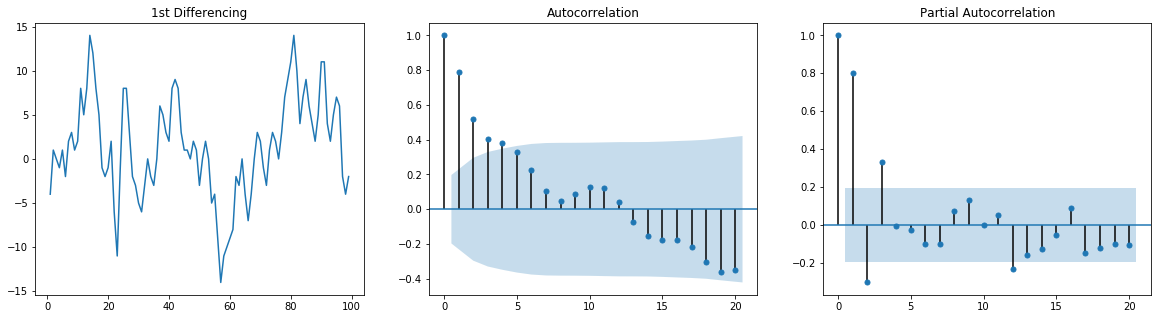

In [11]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
axes[0].plot(series_2.diff()); axes[0].set_title('1st Differencing')
plot_acf(series_2.diff().dropna(), ax=axes[1])
plot_pacf(series_2.diff().dropna(), ax=axes[2])
plt.show()

We can observe that the `PACF lag 1` is `quite significant` since is `well above the significance line` ($\pm 0.2$). `Lag 2` `turns out` to be `significant as well`, slightly managing to cross the `significance limit (blue region)` while `lag 3` is bellow the `significant line` ($-0.2$).

But we am going to be conservative and tentatively fix the `p = 1`.

Now, how about the `#passengers_ts`

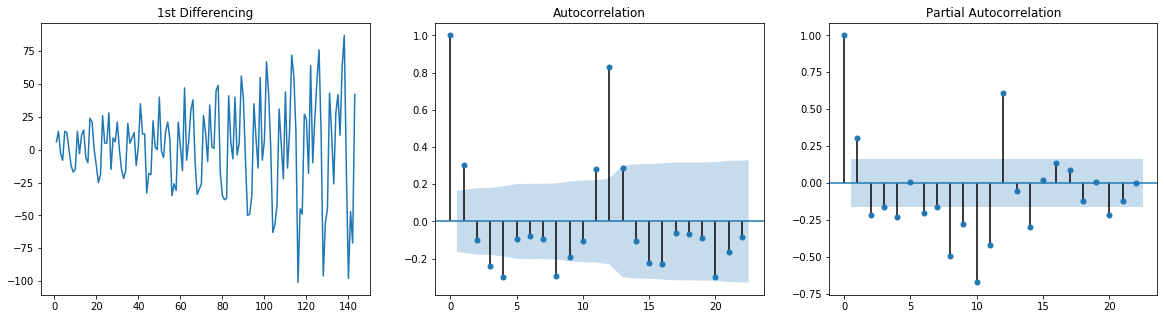

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
axes[0].plot(series_1.diff().values); axes[0].set_title('1st Differencing')
plot_acf(series_1.diff().dropna(), ax=axes[1])
plot_pacf(series_1.diff().dropna(), ax=axes[2])
plt.show()

**Remarks**
Noting that we can use `autocorrelation_plot` in `pandas.plotting` but finding the params `d, p` will be easier when using `plot_pacf` and `plot_acf`

(<matplotlib.axes._subplots.AxesSubplot at 0x208ea77ab88>,
 Text(0.5, 1.0, '#usages'))

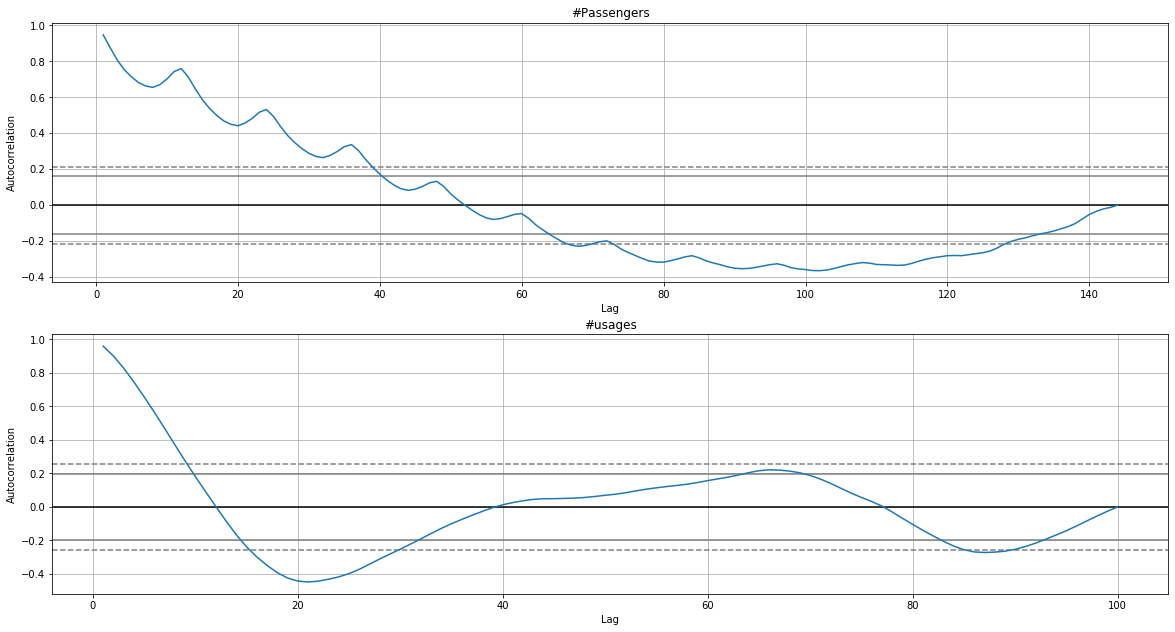

In [13]:
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(2, 1, figsize = (20, 10.5))
autocorrelation_plot(series_1, ax = axes[0]), axes[0].set_title('#Passengers')
autocorrelation_plot(series_2, ax = axes[1]), axes[1].set_title('#usages')

#### 1.2.3. How to find the order of the `MA term`

> Just like how we looked at the `PACF plot` for the number of `AR terms`, 
>
> we can look at the `ACF plot` for the number of `MA terms`. An `MA term` is technically, the `error of the lagged forecast`.

The `ACF` tells how many `MA terms` are required to `remove any autocorrelation in the stationarized series`.

Look at Line [11] and [12] (at `autocorrelation terms`), we tentatively fix `q as 2` for `#passengers_ts` (since the first `couple of lags` are well `above the significance line`) while choosing `q = 3` for `#usages_ts`

### 1.3. How to handle if a time series is slightly under or over differenced
It may so happen that your series is `slightly under differenced`, that differencing it one more time makes it `slightly over-differenced`. How to handle this case?

> If your series is `slightly under differenced`, **adding one or more additional AR terms** usually `makes it up`. 
>
> Likewise, if it is `slightly over-differenced`, try **adding an additional MA term**.

## 2. Implement & optimal an `ARIMA's model`

### 2.1. Build-in an `ARIMA's model`-`python`

Now that you’ve determined the values of `p, d and q`, you have everything needed to fit the `ARIMA model`. Let’s use the `ARIMA()` implementation in `statsmodels package`.

In [14]:
model = ARIMA(series_2.values, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Sun, 02 Aug 2020   AIC                            517.579
Time:                        18:33:46   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1202      1.290      0.868      0.385      -1.409       3.649
ar.L1.D.y      0.6351      0.257      2.469      0.014       0.131       1.139
ma.L1.D.y      0.5287      0.355      1.489      0.1

The `model.summary` reveals a lot of information. The `table` in the `middle` is the `coefficients table` where the `values` under `‘coef’` are the `weights` of the `respective terms`.

Notice here the `coefficient of the MA2 term` is close to `zero` (-0.001) and the `p_Value` in `‘P>|z|’` column is `highly insignificant` (0.998). 

It `should ideally be less than 0.05` for the `respective X to be significant`.

So, let’s rebuild the model without the `MA2 term` (only using MA1 or `q = 1`).

In [15]:
model = ARIMA(series_2.values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Sun, 02 Aug 2020   AIC                            515.579
Time:                        18:33:46   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.y      0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.y      0.5297      0.089      5.932      0.0

The `model AIC` has reduced (from `517.579 with ARIMA(1,1,2)` to `515.579 with ARIMA(1,1,1)`), which is good. The `p_values` of the `AR1` and `MA1 terms` have improved and are `highly significant (<< 0.05)`.

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

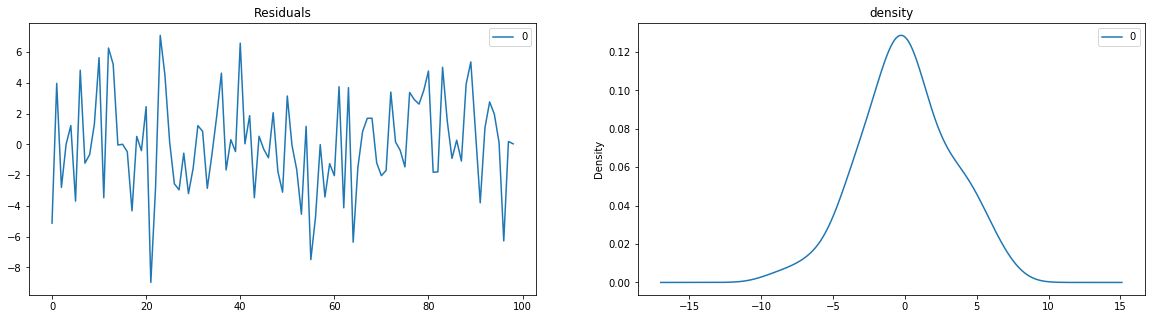

In [16]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(kind = 'kde', title = 'density', ax = ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

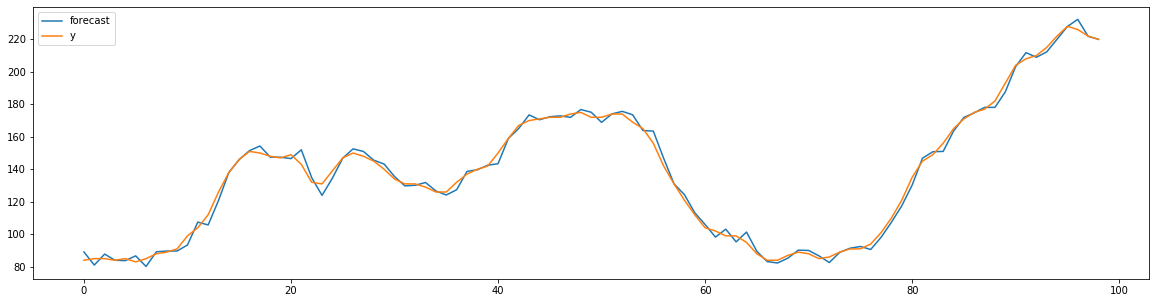

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
model_fit.plot_predict(dynamic=False, ax = ax)
plt.show()

When setting `dynamic=False` the in-sample `lagged values` are used for `prediction`.

That is, the model gets `trained up until the previous value to make the next prediction`. This can make the `fitted forecast` and `actuals look artificially good`.

### Example 4. How about `#passenger_ts`

In [18]:
model = ARIMA(series_1.values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -697.073
Method:                       css-mle   S.D. of innovations             31.338
Date:                Sun, 02 Aug 2020   AIC                           1402.145
Time:                        18:33:47   BIC                           1413.997
Sample:                             1   HQIC                          1406.961
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6112      0.228     11.435      0.000       2.164       3.059
ar.L1.D.y      0.7400      0.058     12.778      0.000       0.626       0.854
ma.L1.D.y     -1.0000      0.019    -53.425      0.0

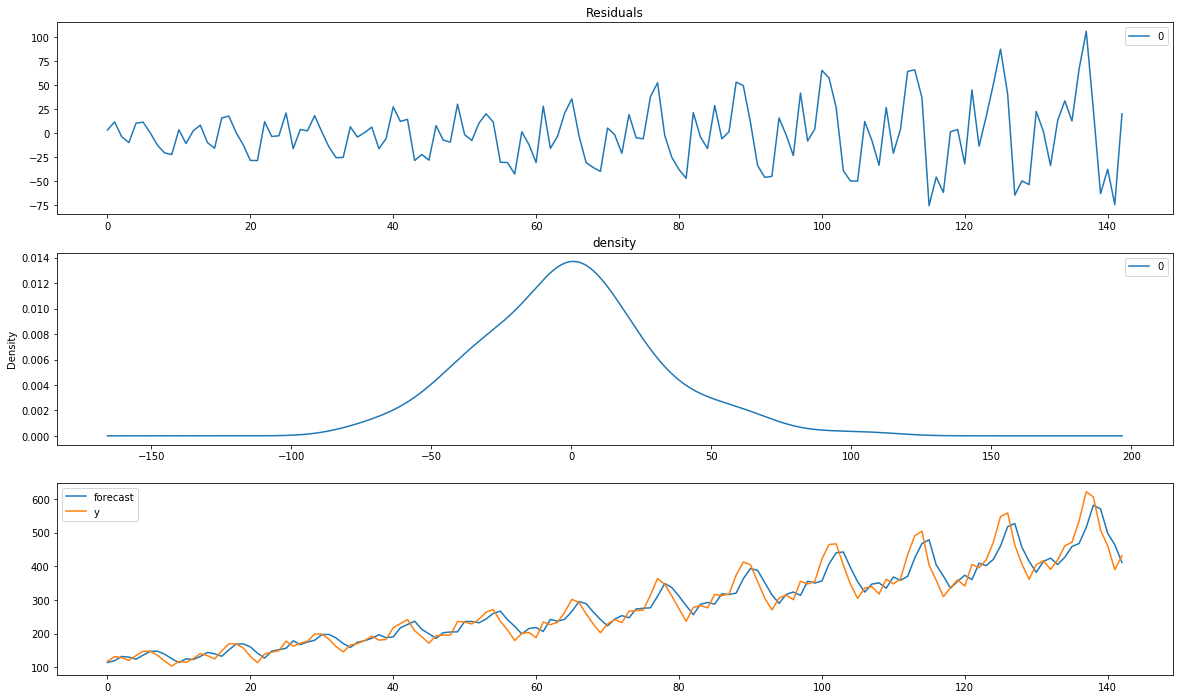

In [19]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(3, 1, figsize = (20, 12))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='density', ax=ax[1])
model_fit.plot_predict(dynamic=False, ax = ax[2])

plt.show()

So, we seem to have a `decent ARIMA model`. But is that the best?

Can’t say that at this point because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

So, the `real validation` you need now is the **`Out-of-Time cross-validation` (OOT-CV)**.

### 2.2. How to do find the `optimal ARIMA model` manually using `OOT-CV`

In `OOT-CV`, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do `out-of-time cross-validation`, we need to create the `training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio` or a reasonable proportion based on time frequency of series.

Why am I not sampling the training data randomly you ask?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.

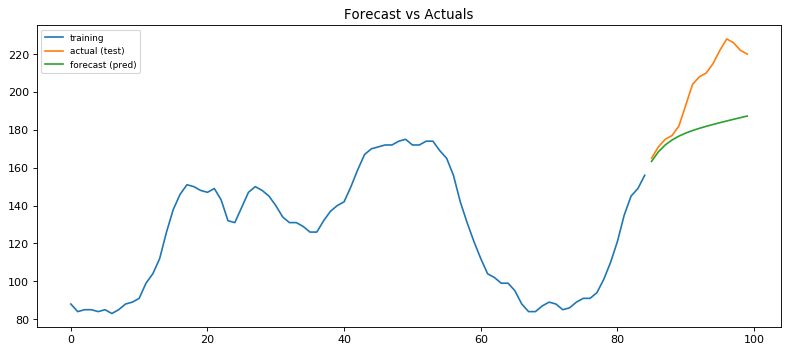

In [20]:
train_size = int(0.85*len(series_2))
train = series_2[: train_size]
test = series_2[train_size : ]
test_size = len(test)

model = ARIMA(train.values, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(test_size, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi = 80)
plt.plot(train, label='training')
plt.plot(test, label='actual (test)')
plt.plot(fc_series, label='forecast (pred)')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

So, what I am going to do is to increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

While doing this, I keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.

                             ARIMA Model Results                              
Dep. Variable:                   D2.x   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Sun, 02 Aug 2020   AIC                            440.497
Time:                        18:33:48   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0483      0.084      0.577      0.564      -0.116       0.212
ar.L1.D2.x     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.x    -0.5923      0.155     -3.827      0.0

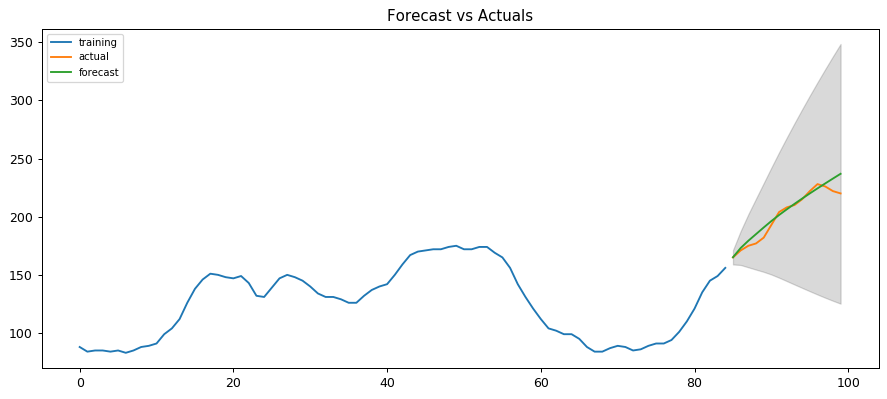

In [21]:
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=90)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The AIC has reduced to 440 from 515. Good. The P-values of the X terms are less the < 0.05, which is great.

So overall it’s much better.

Ideally, you should go back multiple points in time, like, go back 1, 2, 3 and 4 quarters and see how your forecasts are performing at various points in the year.

Here’s a great practice exercise: Try to go back 27, 30, 33, 36 data points and see how the forcasts performs. The forecast performance can be judged using various accuracy metrics discussed next.

### Next, we try with the data `#passengers`

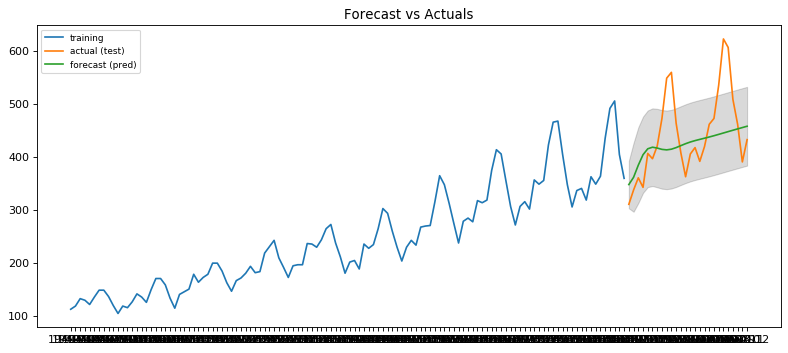

In [22]:
train_size = int(0.82*len(series_1))
train = series_1[: train_size]
test = series_1[train_size : ]
test_size = len(test)

model = ARIMA(train.values, order=(3, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(test_size, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi = 80)
plt.plot(train, label='training')
plt.plot(test, label='actual (test)')
plt.plot(fc_series, label='forecast (pred)')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  116
Model:                 ARIMA(9, 2, 1)   Log Likelihood                -517.847
Method:                       css-mle   S.D. of innovations             19.988
Date:                Sun, 02 Aug 2020   AIC                           1059.694
Time:                        18:33:52   BIC                           1092.737
Sample:                             2   HQIC                          1073.107
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.019      0.645      0.519      -0.025       0.049
ar.L1.D2.y     0.0669      0.089      0.751      0.453      -0.108       0.242
ar.L2.D2.y    -0.3879      0.082     -4.704      0.0

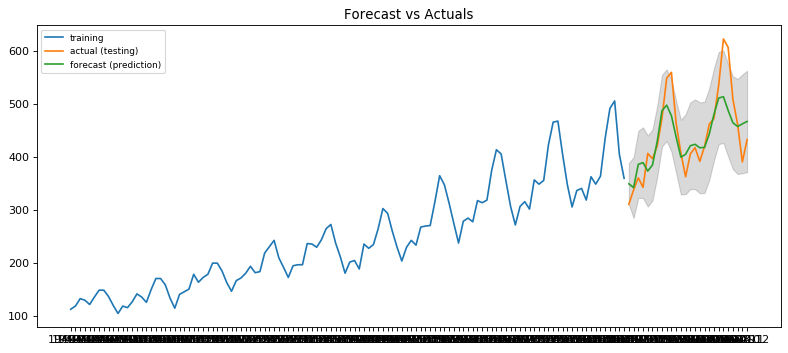

In [23]:
model = ARIMA(train.values, order=(9, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(26, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi = 80)
plt.plot(train, label='training')
plt.plot(test, label='actual (testing)')
plt.plot(fc_series, label='forecast (prediction)')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 2.3.  Accuracy Metrics for Time Series Forecast
The `commonly used accuracy metrics` to judge `forecasts` are:

> `Mean Absolute Percentage Error (MAPE)`
$$ \text{MAPE} = \dfrac{1}{N_{\text{test}}} \sum_{k=1}^{N_{\text{test}}} \left\vert \dfrac{y_{\text{pred}}^{(k)} - y_{\text{test}}^{(k)} }{y_{\text{test}}^{(k)}} \right\vert $$
> `Mean Error (ME)`
$$ \text{ME} = \dfrac{1}{N_{\text{test}}} \sum_{k=1}^{N_{\text{test}}} \left( y_{\text{pred}}^{(k)} - y_{\text{test}}^{(k)} \right) $$
> `Mean Absolute Error (MAE)`
$$ \text{MAE} = \dfrac{1}{N_{\text{test}}} \sum_{k=1}^{N_{\text{test}}} \left\vert y_{\text{pred}}^{(k)} - y_{\text{test}}^{(k)} \right\vert $$
> `Mean Percentage Error (MPE)`
$$ \text{MPE} = \dfrac{1}{N_{\text{test}}} \sum_{k=1}^{N_{\text{test}}} \left( \dfrac{y_{\text{pred}}^{(k)} - y_{\text{test}}^{(k)} }{y_{\text{test}}^{(k)}} \right) $$
> `Root Mean Squared Error (RMSE)`
$$ \text{RMSE} = \left[ \dfrac{1}{N_{\text{test}}} \sum_{k=1}^{N_{\text{test}}} \left( \dfrac{y_{\text{pred}}^{(k)} - y_{\text{test}}^{(k)} }{y_{\text{test}}^{(k)}} \right)^2 \right]^{1/2} $$
> `Lag 1 Autocorrelation of Error (ACF1)`
$$ \text{ACF1} = \dfrac{\Sigma_1}{\Sigma_0} $$
where 
$$ \Sigma_k = N_{\text{test}}^{-1} \sum_{i = k+1}^{N_{\text{test}}} \left( 
y_{\text{pred}}^{(i)} - y_{\text{test}}^{(i)} - \bar{y}  \right) \left( 
y_{\text{pred}}^{(i-k)} - y_{\text{test}}^{(i-k)} - \bar{y} \right); \qquad k = 0, 1. $$
and $$ \bar{y} = N_{\text{test}}^{-1} \sum_{i=1}^{N_{\text{test}}} \left( y_{\text{pred}}^{(i)} - y_{\text{test}}^{(i)} \right) $$
> `Correlation between the Actual and the Forecast (corr)`
$$ \text{corr} = \dfrac{ \text{Cov} \left( y_{\text{pred}}, y_{\text{test}} \right) }{\sqrt{ \text{Var} \left( y_{\text{pred}} \right) \text{Var} \left( y_{\text{test}} \right) } }  $$
> `Min-Max Error (minmax)`
$$ \text{minmax} = 1 - N_{\text{test}}^{-1} \sum_{i = 1}^{N_{\text{test}}} \left( \dfrac{\min \left\lbrace y_{\text{pred}}^{(i)}, y_{\text{test}}^{(i)} \right\rbrace }{\max \left\lbrace y_{\text{pred}}^{(i)}, y_{\text{test}}^{(i)} \right\rbrace } \right) $$
Typically, if you are comparing forecasts of two different series, the `MAPE`, `Correlation` and `Min-Max Error` can be used.

Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.

The other error metrics are quantities. That implies, an `RMSE` of 100 for a series whose mean is in 1000’s is better than an `RMSE` of 5 for series in 10’s. So, you can’t really use them to compare the forecasts of two different scaled time series.

In [24]:
from statsmodels.tsa.stattools import acf

## train-test-split
train_size = int(0.82*len(series_1))
train = series_1[: train_size]
test = series_1[train_size : ]
test_size = len(test)

print(train.shape, fc.shape, test.values.shape)

## initialize & fit model
model = ARIMA(train.values.reshape(-1), order = (9, 2, 1))  
fitted = model.fit(disp=-1)  

## predict
fc, se, conf = fitted.forecast(len(test.values), alpha=0.05)

(118, 1) (26,) (26, 1)


So, to evaluate the accuracy and error between `actual (test)` and `predict (forecast)`, we must `reshape` to a `coincided dimension`!

In [25]:
print('Mean Absolute Percentage Error (mape): ', 
      np.mean(np.abs( fc- test.values.reshape(-1) )/np.abs(test.values.reshape(-1))) )
print('Corrlation (corr) :', 
      np.corrcoef(fc, test.values.reshape(-1))[0,1])
print('Mean error (ME) :', 
      np.mean(fc - test.values.reshape(-1)))
print('Mean absolute error (mae): ', 
      np.mean(np.abs(fc - test.values.reshape(-1))) )
print('Mean percentage Error (mpe):', 
      np.mean((fc - test.values.reshape(-1))/test.values.reshape(-1)))
print('Root Mean Squared Error (rmse) :', 
      np.mean((fc - test.values.reshape(-1))**2)**.5)
print('Lag 1 Autocorrelation of Error (acf1) :', 
      acf(fc -  test.values.reshape(-1), fft = False)[1])
mins = np.amin(np.hstack([fc[:,None], 
                          test.values.reshape(-1)[:,None]]), axis=1)
maxs = np.amax(np.hstack([fc[:,None], 
                          test.values.reshape(-1)[:,None]]), axis=1)
print('Minmax error:', 1 - np.mean(mins / maxs))

Mean Absolute Percentage Error (mape):  0.07297343391058791
Corrlation (corr) : 0.8695798179387235
Mean error (ME) : -7.324422252307108
Mean absolute error (mae):  33.65649649594971
Mean percentage Error (mpe): -0.002738732117976994
Root Mean Squared Error (rmse) : 45.56897200010805
Lag 1 Autocorrelation of Error (acf1) : 0.5247336010033643
Minmax error: 0.06954586288545228


#### How about `#usages_ts`

In [26]:
train_size = int(0.85*len(series_2))
train = series_2[: train_size]
test = series_2[train_size : ]
test_size = len(test)
model = ARIMA(train.values, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(test.values), alpha=0.05)

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast - actual, fft = False)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.022501321535548884,
 'me': 3.230787840225757,
 'mae': 4.548323885772553,
 'mpe': 0.016421023805157427,
 'rmse': 6.373241854572394,
 'acf1': 0.5105505390497768,
 'corr': 0.9674576472243268,
 'minmax': 0.02163155474721734}

Around `2.2% MAPE` implies the model is about `97.8% accurate` in predicting the next `15 observations` (in total 100 obs in this dataset).

Now, we know how to build an `ARIMA model manually`. But `in industrial situations`, we will be given a lot of time series to be forecasted and the forecasting exercise be repeated regularly.

So we need a way to automate the `best model selection process`.

### 2.4. Implement `Auto Arima Forecast` in `Python`
Like `R`’s popular `auto.arima()` function, the `pmdarima package` provides `auto_arima()` with similar functionality.

`auto_arima()` uses a `stepwise` approach to search multiple combinations of `p,d,q parameters` and chooses the best model that has the least `AIC`.

In [27]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm    ## !pip3 install pyramid-arima

model_2 = pm.auto_arima(series_2.values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_2.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=525.587, BIC=535.926, Time=0.046 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=533.474, BIC=538.644, Time=0.007 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=532.437, BIC=540.192, Time=0.026 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=525.893, BIC=533.648, Time=0.031 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=531.477, BIC=534.062, Time=0.009 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=515.248, BIC=528.173, Time=0.065 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=513.459, BIC=523.799, Time=0.053 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=515.284, BIC=528.209, Time=0.043 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=512.555, BIC=528.065, Time=0.278 seconds
Near non-invertible roots for order (3, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit cir

In [28]:
model_1 = pm.auto_arima(series_1, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=9, max_q=5, # maximum p and q
                      m=1,              
                      d=None,            
                      seasonal= False,   
                      start_P=1, 
                      D = 0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_1.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1790.368, BIC=1796.307, Time=0.009 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=1428.179, BIC=1437.089, Time=0.044 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=1621.713, BIC=1630.623, Time=0.050 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=2057.847, BIC=2060.817, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=1413.639, BIC=1425.518, Time=0.093 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=1410.342, BIC=1425.191, Time=0.170 seconds
Fit ARIMA(4,0,0)x(0,0,0,0) [intercept=True]; AIC=1409.758, BIC=1427.577, Time=0.202 seconds
Fit ARIMA(5,0,0)x(0,0,0,0) [intercept=True]; AIC=1404.241, BIC=1425.030, Time=0.233 seconds
Fit ARIMA(6,0,0)x(0,0,0,0) [intercept=True]; AIC=1406.045, BIC

### 2.5. Interpret the `residual plots` in `ARIMA model`

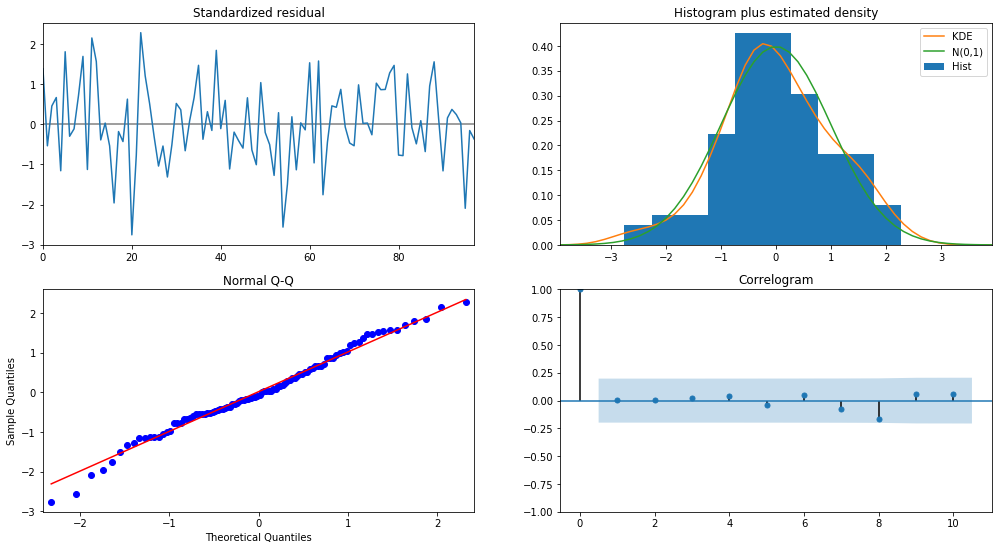

In [29]:
model_2.plot_diagnostics(figsize=(17, 9))
plt.show()

> **`Top left:`** The `residual errors` seem to fluctuate around a mean of zero and have a `uniform variance`.
>
> **`Top Right:`** The density plot suggest `normal distribution` with `zero-mean`.
>
> **`Bottom left:`** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is `skewed`.
>
> **`Bottom Right:`** The `Correlogram`, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s forecast.

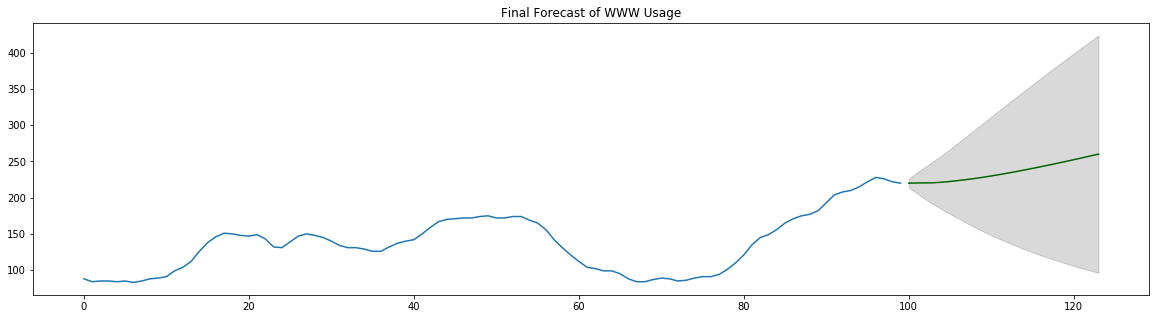

In [30]:
n_periods = 24
fc, confint = model_2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(series_2), len(series_2) + n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize = (20, 5))
plt.plot(series_2)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast of WWW Usage")
plt.show()

How about `model_1` with `#passengers_ts`

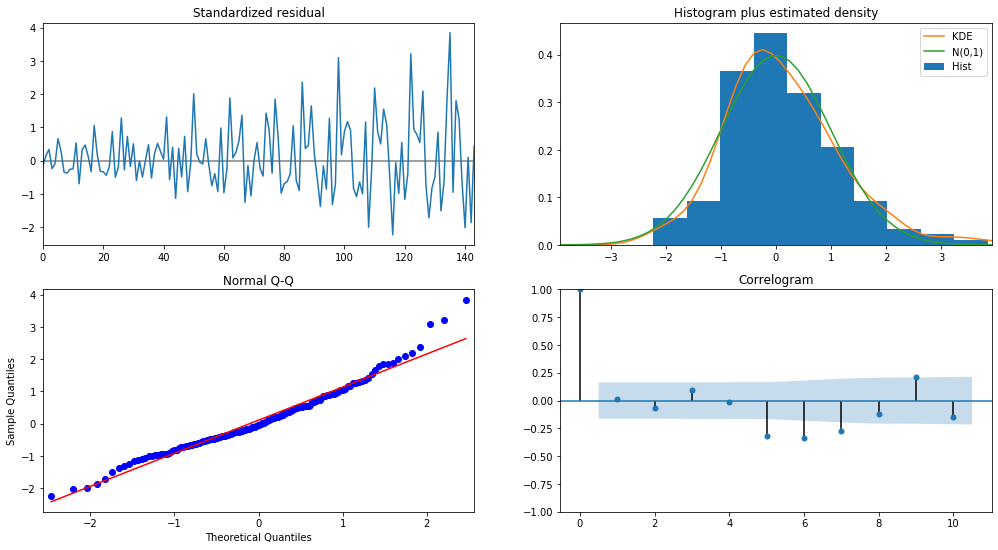

In [31]:
model_1.plot_diagnostics(figsize=(17, 9))
plt.show()

<Figure size 1440x360 with 0 Axes>

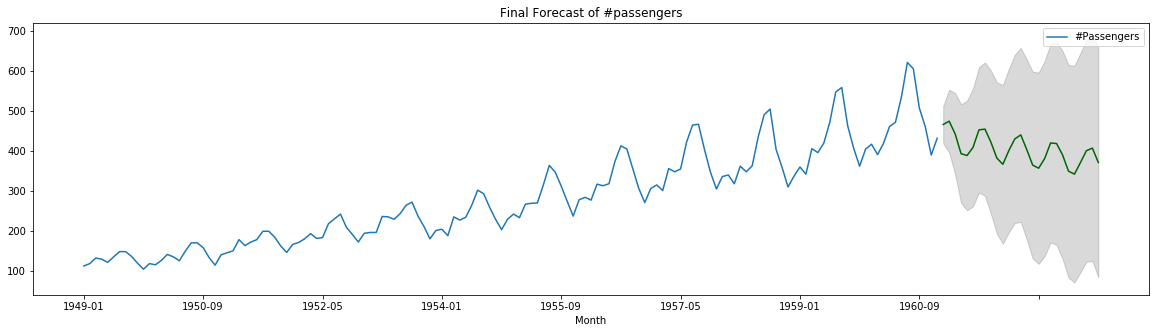

In [32]:
n_periods = 27
fc, confint = model_1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(series_1), len(series_1) + n_periods)

fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.figure(figsize = (20, 5))
series_1.plot(figsize = (20, 5))
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast of #passengers")
plt.show()

## 3. `SARIMA model`

The problem with `plain ARIMA model` is it does not `support seasonality`.

If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

So, the model will be represented as `SARIMA(p,d,q)x(P,D,Q)`, where, `P, D and Q` are `SAR`, `order of seasonal differencing` and `SMA terms` respectively and `'x'` is the `frequency` of the `time series`.

If your model has `well defined seasonal patterns`, then `enforce D=1` for a given frequency `‘x’`.


### 3.1 Build `SARIMA model` in python automatically

Here’s some practical advice on building `SARIMA model`:

As a `general rule`, set the `model parameters` such that
> **`D never exceeds one`**. and
>
> the **`total differencing ‘d + D’ never exceeds 2`**. 
>
> Try to **`keep only either SAR or SMA terms if your model has seasonal components`**.

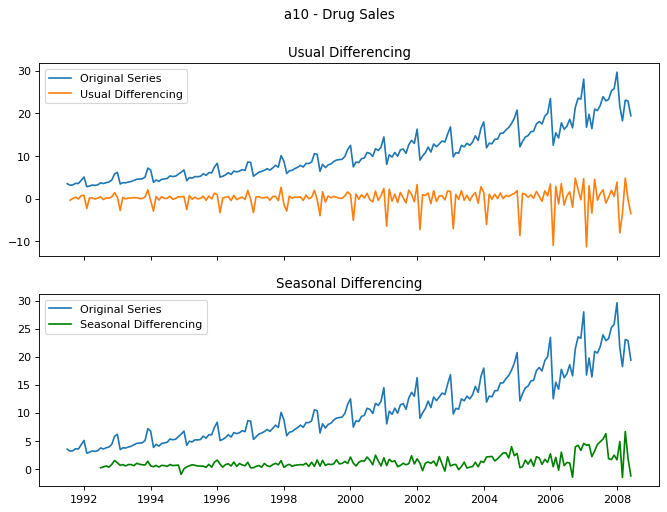

In [33]:
df3 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', 
                  parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 7), dpi = 80, sharex=True)

# Usual Differencing
axes[0].plot(df3[:], label='Original Series')
axes[0].plot(df3[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df3[:], label='Original Series')
axes[1].plot(df3[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=12)
plt.show()

As you can clearly see, the seasonal spikes is intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

To build the `SARIMA model using pmdarima‘s auto_arima()`, we need to set **`seasonal=True`**, set the frequency **`m=12`** for `month wise series` and `enforce D=1`.

In [34]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df3, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=534.818, BIC=551.105, Time=0.794 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=624.061, BIC=630.576, Time=0.097 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=596.068, BIC=609.098, Time=0.314 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=611.475, BIC=624.505, Time=0.257 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=757.274, BIC=760.532, Time=0.021 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=559.407, BIC=572.437, Time=0.194 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=554.646, BIC=574.191, Time=1.209 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=536.817, BIC=556.362, Time=2.773 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=543.106, BIC=559.39

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  204
Model:             SARIMAX(3, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -250.092
Date:                                 Sun, 02 Aug 2020   AIC                            518.184
Time:                                         18:35:30   BIC                            547.501
Sample:                                              0   HQIC                           530.058
                                                 - 204                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0250      0.033      0.749      0.454      -0.040       0.090
ar.L1         -0.1236      0.149     -0.829      0.407      -0.416       0.169
ar.L2          0.4831      0.061      7.891      0.000       0.363       0.603
ar.L3          0.5240      0.083      6.343      0.000       0.362       0.686
ma.L1          0.1930      0.164      1.179      0.238      -0.128       0.514
ar.S.L12       0.8415      0.123      6.859      0.000       0.601       1.082
ma.S.L12      -1.6404      0.160    -10.280      0.000      -1.953      -1.328
ma.S.L24       0.8329      0.124      6.724      0.000       0.590       1.076
sigma2         0.6943      0.084      8.267      0.000       0.530       0.859
===================================================================================
Ljung-Box (Q):                       61.11   Jarque-Bera (JB):               103.78
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.74   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The `model` has estimated the `AIC` and the `p_values` of the `coefficients` look `significant`. Let’s look at the `residual diagnostics plot`.

The best model `SARIMAX(3, 0, 0)x(0, 1, 1, 12)` has an `AIC` of `528.6` and the `p_values` are `significant`.

Let’s forecast for `the next 24 months`.

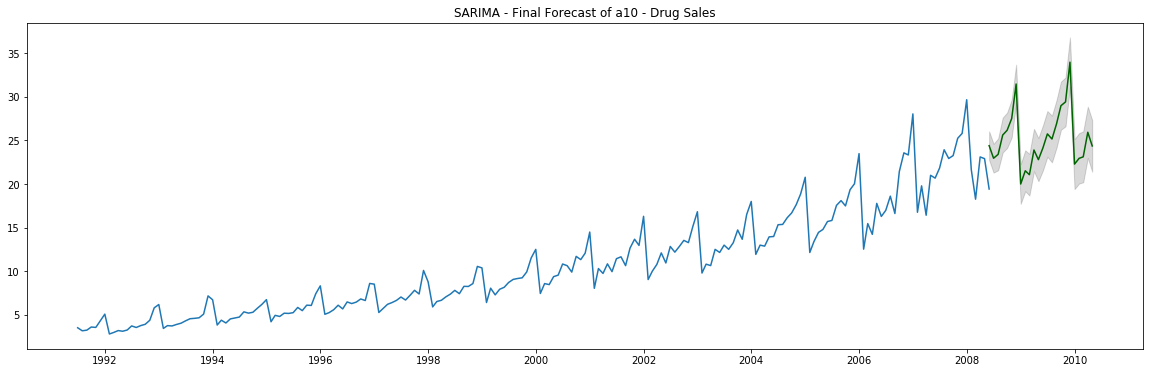

In [35]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df3.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize = (20, 6))
plt.plot(df3)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

There you have a nice forecast that captures the expected seasonal demand pattern.

Now, try again with `#passengers.csv`

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=1024.824, BIC=1039.200, Time=0.342 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1033.479, BIC=1039.229, Time=0.020 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=1022.316, BIC=1033.817, Time=0.269 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=1022.904, BIC=1034.405, Time=0.281 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1031.508, BIC=1034.383, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,1,0,12) [intercept=True]; AIC=1022.343, BIC=1030.968, Time=0.079 seconds
Fit ARIMA(1,1,0)x(2,1,0,12) [intercept=True]; AIC=1021.137, BIC=1035.513, Time=0.811 seconds
Fit ARIMA(1,1,0)x(2,1,1,12) [intercept=True]; AIC=1017.164, BIC=1034.415, Time=3.200 seconds
Near non-invertible roots for order (1, 1, 0)(2, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(1,1,0)x(1,1,1,12) [intercept=True]; AIC=102

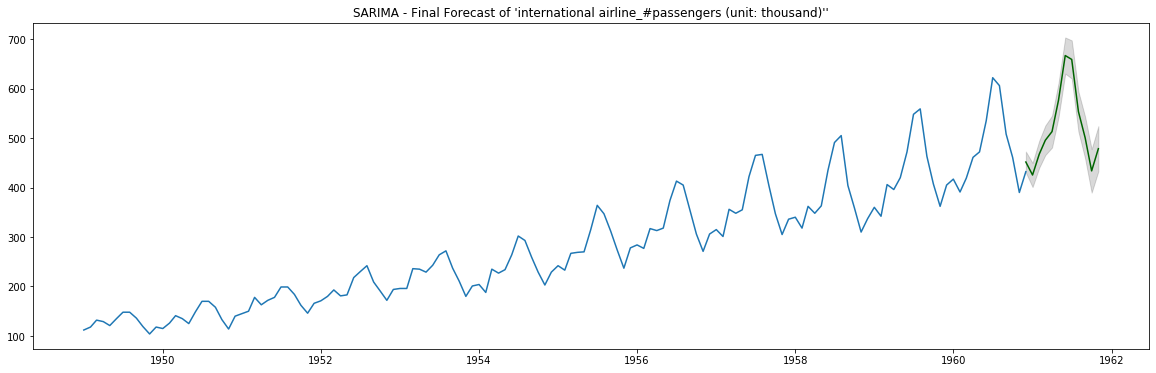

In [36]:
df1 = pd.read_csv(r"D:\Nhan\Data\AirPassengers.csv",
                  parse_dates=['Month'], index_col='Month')

smodel = pm.auto_arima(df1, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df1.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize = (20, 6))
plt.plot(df1)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of 'international airline_#passengers (unit: thousand)''")
plt.show()

### 3.2. Build `SARIMAX model` with `exogenous variable`
The `SARIMA model` we built is good. I would stop here typically.

But for the sake of completeness, let’s try and force an external predictor, also called, ‘exogenous variable’ into the model. This model is called the `SARIMAX model`.

The only requirement to use an `exogenous variable` is you need to know the value of the variable during the forecast period as well.

For the sake of demonstration, I am going to use the seasonal index from the `classical seasonal decomposition` on the `latest 36 months` of data.

Why the seasonal index? Isn’t `SARIMA` already modeling the `seasonality`??

Well, but also, I want to see how the model looks if we force the recent seasonality pattern into the training and forecast.

Secondly, this is a good variable for demo purpose. So you can use this as a template and plug in any of your variables into the code. The `seasonal index` is a `good exogenous variable` because it repeats every `frequency cycle`, `12 months` in this case.

So, you will always know what values the seasonal index will hold for the `future forecasts`

Let’s compute the seasonal index so that it can be forced as a `(exogenous) predictor` to the `SARIMAX model`.

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(df3['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
df3['month'] = df3.index.month
df = pd.merge(df3, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = df3.index  # reassign the index.

The `exogenous variable` (`seasonal index`) is ready. Let’s build the `SARIMAX model`.

In [38]:
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=536.818, BIC=556.362, Time=0.968 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=626.061, BIC=635.834, Time=0.044 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=598.068, BIC=614.356, Time=0.391 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=613.475, BIC=629.762, Time=0.314 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=759.274, BIC=765.789, Time=0.094 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=561.407, BIC=577.695, Time=0.252 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=556.381, BIC=579.183, Time=1.496 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=538.817, BIC=561.620, Time=4.017 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=545.106, BIC=564.65

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -250.498
Date:                                 Sun, 02 Aug 2020   AIC                            518.995
Time:                                         18:36:34   BIC                            548.313
Sample:                                     07-01-1991   HQIC                           530.869
                                          - 06-01-2008                                         
Covariance Type:                                   opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0205      0.028      0.742      0.458      -0.034       0.075
seasonal_index   7.12e-06   5.18e+04   1.37e-10      1.000   -1.02e+05    1.02e+05
ar.L1              0.0397      0.048      0.823      0.410      -0.055       0.134
ar.L2              0.4331      0.039     11.154      0.000       0.357       0.509
ar.L3              0.4346      0.056      7.759      0.000       0.325       0.544
ar.S.L12           0.8393      0.122      6.875      0.000       0.600       1.079
ma.S.L12          -1.6430      0.168     -9.795      0.000      -1.972      -1.314
ma.S.L24           0.8395      0.132      6.366      0.000       0.581       1.098
sigma2             0.6953      0.082      8.437      0.000       0.534       0.857
===================================================================================
Ljung-Box (Q):                       63.30   Jarque-Bera (JB):               118.34
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              13.06   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So, we have the model with the exogenous term. But the `coefficient` is very small for `x1`, so the contribution from that variable will be `negligible`. Let’s forecast it anyway.

We have effectively forced the `latest seasonal effect` of the `latest 3 years` into the model `instead` of the `entire history`.

Alright let’s forecast into the `next 24 months`. For this, you need the value of the seasonal index for the `next 24 months`.

In [39]:
seasonal_index

,seasonal,month
date,,
2007-07-01,0.970490,7
2007-08-01,1.050900,8
2007-09-01,0.998881,9
2007-10-01,1.059657,10
2007-11-01,1.146141,11
2007-12-01,1.150750,12
2008-01-01,1.316913,1
2008-02-01,0.803279,2
2008-03-01,0.850667,3


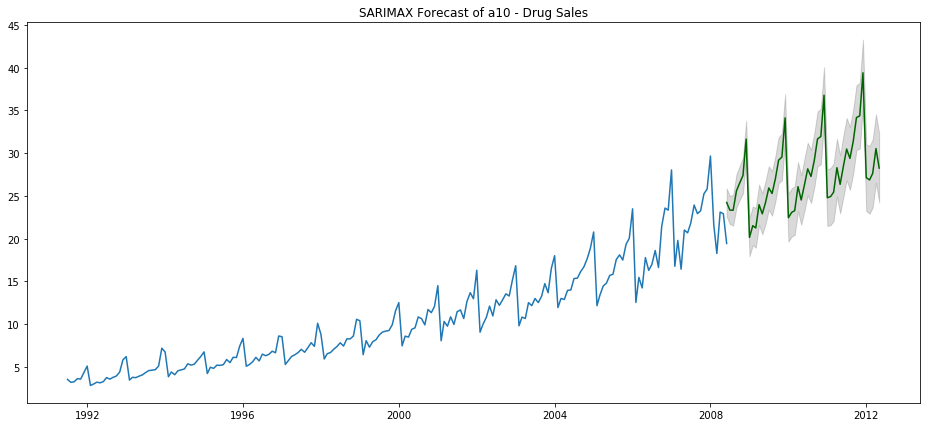

In [40]:
n_periods = 48
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.values, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize = (16, 7))
plt.plot(df['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

### Similar to `#passengers.csv`

In [41]:
result_mul = seasonal_decompose(df1['#Passengers'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
df1['month'] = df1.index.month
df = pd.merge(df1, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = df1.index  # reassign the index.
df.head()

,value,month,seasonal_index
Month,,,
1949-01-01,112,1,0.920630
1949-02-01,118,2,0.856424
1949-03-01,132,3,0.959662
1949-04-01,129,4,0.958901
1949-05-01,121,5,0.990109


In [42]:
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=1026.664, BIC=1043.960, Time=0.541 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=1137.540, BIC=1146.189, Time=0.039 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=1028.721, BIC=1043.135, Time=0.474 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=1081.510, BIC=1095.924, Time=0.372 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=1326.954, BIC=1332.720, Time=0.104 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=1026.399, BIC=1040.813, Time=0.218 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=1026.219, BIC=1043.516, Time=0.726 seconds
Fit ARIMA(1,0,1)x(2,1,0,12) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=1026.773, BIC=1046.952, Time=1.219 seconds
Fit ARIMA(1,0,1)x(2,1,1,12) [intercept=True]; AIC=1023.123, BIC=1046.186, Time=4.070 seconds
Near non-invertible roots for order (1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -503.562
Date:                            Sun, 02 Aug 2020   AIC                           1023.123
Time:                                    18:36:50   BIC                           1046.186
Sample:                                01-01-1949   HQIC                          1032.495
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0397      0.552      0.072      0.943      -1.042       1.121
seasonal_index     0.0085    408.496   2.08e-05      1.000    -800.628     800.645
ar.L1              0.9044      0.058     15.715      0.000       0.792       1.017
ma.L1             -0.3421      0.089     -3.841      0.000      -0.517      -0.168
ar.S.L12           0.6905      0.209      3.297      0.001       0.280       1.101
ar.S.L24           0.2962      0.114      2.609      0.009       0.074       0.519
ma.S.L12          -0.9311      0.483     -1.927      0.054      -1.878       0.016
sigma2           111.7399     29.699      3.762      0.000      53.531     169.949
===================================================================================
Ljung-Box (Q):                       52.65   Jarque-Bera (JB):                11.36
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               2.64   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

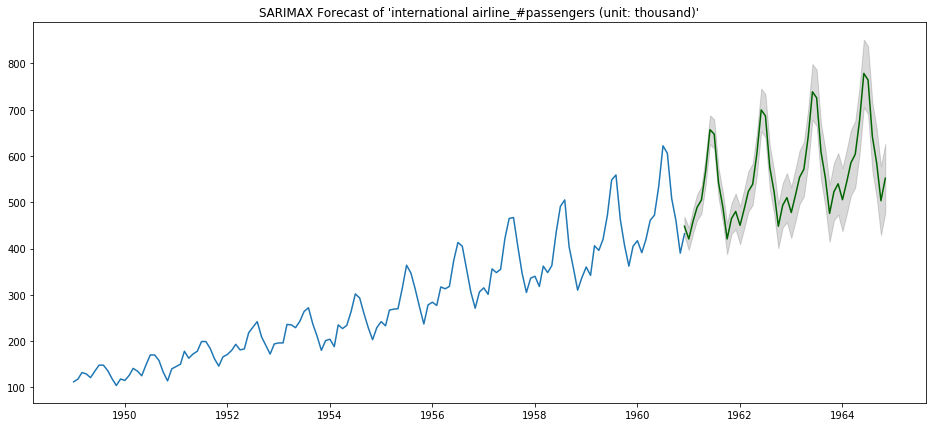

In [43]:
n_periods = 48
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.values, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize = (16, 7))
plt.plot(df['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of 'international airline_#passengers (unit: thousand)'")
plt.show()